In [1]:
import pandas as pd
import numpy as np
import sympy


In [2]:
def create_df_response(samples, time,  quantiles = [50, 80, 95], forecast_horizon=27, date_init=None, sample_freq="D", dates=None, use_future=False):
    """ Create a dataframe with the quantiles of the model and forecast if provided

    Args:
        samples: Samples of the variable to create the dataframe
        time:    [description]
        date_init (str, optional): [description]. Defaults to '2020-03-06'.
        forecast_horizon (int, optional): [description]. Defaults to 27.
        use_future (bool, optional): [description]. Defaults to False.

    Returns:
        [type]: [description]
    """

    if samples.shape[-1] != time:
        raise Exception("Samples second dimension must be equal to time")

    if dates is not None:
        dates_fitted = dates
    elif date_init is not None and sample_freq is not None:
        dates_fitted = pd.date_range(pd.to_datetime(date_init), periods=time, freq=sample_freq)

    else:
        dates_fitted   = list(range(time))
        dates_forecast = list(range(time, time+forecast_horizon))

    dates = dates_fitted
    types = ['estimate']*len(dates_fitted)

    if use_future:
        dates += list(dates_forecast)
        types += ['forecast']*len(dates_forecast)

    results_df  = pd.DataFrame(samples.T)
    df_response = pd.DataFrame(index=dates)

    # Calculate key statistics
    df_response['mean']        = results_df.mean(axis=1).values
    df_response['median']      = results_df.median(axis=1).values
    df_response['std']         = results_df.std(axis=1).values

    for quant in quantiles:
        low_q  = ((100-quant)/2)/100
        high_q = 1-low_q
        df_response[f'low_{quant}']  = results_df.quantile(q=low_q, axis=1).values
        df_response[f'high_{quant}'] = results_df.quantile(q=high_q, axis=1).values

    df_response['type']        =  types
    df_response.index.name = 'date'

    return df_response


# Possible serial interval types considered

dist_names = ['exponential', 'gamma', 'delta', 'bimodal']

def gamma_dist(p, x, shape):
    """
    Gamma distribution, p is 1/mean, shape param preset
    """
    # mean = shape * scale
    scale = 1 / (p * shape)
    rate  = 1/ scale

    # Gamma (Erlang) probabilities
    pr   = -np.log(np.math.factorial(shape-1)) + shape*np.log(rate) + (shape-1)*np.log(x) - rate*x
    return np.exp(pr)


def delta_dist(p, xmax, n_win):
    """
    Delta distribution, 1/p is mean
    """
    pr = np.zeros(xmax)

    # Num time points either side of omega
    a = round(1/p) - (n_win - 1) / 2
    b = round(1/p) + (n_win - 1) / 2

    pr[a:b+1] =  1 / n_win

    return pr

In [3]:

gamma_priors = {}
gamma_priors["shape"] = 20
gamma_priors["scale"] = 20
gamma_priors["omega"] = 14.2


In [19]:
# Renewal model with R and serial interval densities
T        = 365
m        = 300
si_dist  = lambda p: gamma_dist(p, np.arange(1, T), gamma_priors["shape"])


# Constant R
Rt = 1.8*np.ones((T, m))

# Daily incidence
inf = np.zeros((T, m))

# Infectiousness, Poisson rate
λ    = np.zeros((T, m))
rate = np.zeros((T, m))

# Initialise epidemic
inf[0] = 10

N = 1e6
sus    = np.zeros((T, m))
sus[0] = N - inf[0]


# Renewal model
for t in range(1, T):

    # Relevant part of serial distribution
    Pomegat = si_dist(1/gamma_priors["omega"])[:t]

    # Total infectiousness
    λ[t, :] =   np.dot(np.flip(inf[:t, :]).T, Pomegat)

    # Rate for ith day incidence
    rate[t, :] = λ[t, :] * Rt[t, :]

    # Renewal incidence
    inf[t, :] = np.random.poisson(sus[t-1, :]/N * rate[t, :], m)
    sus[t, :] = sus[t-1, :] - inf[t, :]


In [29]:
si_dist(1/gamma_priors["omega"]).shape

(364,)

Text(0, 0.5, 'Probability')

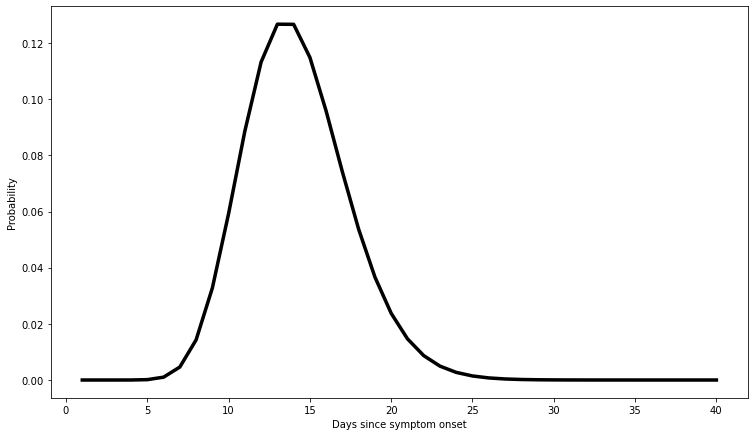

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12.5, 7.2))

ax.plot(np.arange(1, T)[:40], si_dist(1/gamma_priors["omega"])[:40], color="k", lw=3.5, label="Serial interval")
ax.set_xlabel("Days since symptom onset")
ax.set_ylabel("Probability")


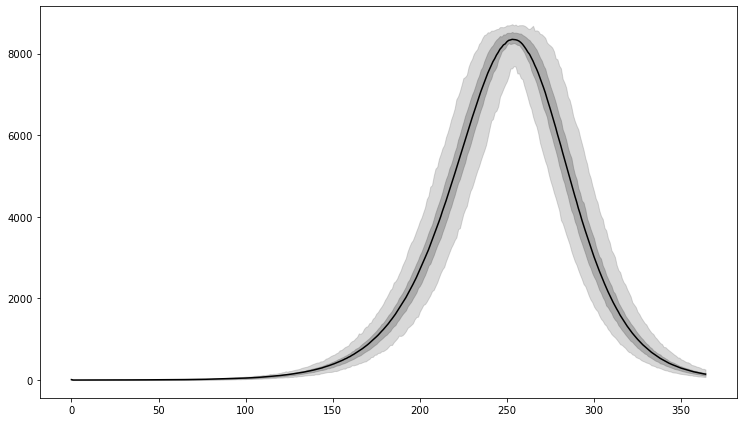

In [26]:

inf_df  = create_df_response(inf.T, T)

fig, ax = plt.subplots(1, 1, figsize=(12.5, 7.2))
ax.plot(inf_df.index.values, inf_df['mean'], color="k")
ax.fill_between(inf_df.index.values, inf_df['low_50'], inf_df['high_50'], alpha=0.5, color="gray")
ax.fill_between(inf_df.index.values, inf_df['low_95'], inf_df['high_95'], alpha=0.3, color="gray")
